<a href="https://colab.research.google.com/github/robinnewhouse/ATLAS-Large-Radius-Tracking/blob/master/LRTTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [146]:
import pandas as pd
import sklearn
import uproot
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model

import matplotlib.lines as mlinesZ
import json
import datetime
import time
import os
import warnings
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, scale
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import class_weight
plt.style.use('seaborn-deep')

In [147]:
# tf.debugging.set_log_device_placement(True)
# Use this line to enable GPU (only on applicable architecures)
tf.config.list_physical_devices('GPU')
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" # turns off gpu
# print(tf.config.list_physical_devices('GPU'))
tf.test.is_gpu_available()
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [148]:
# fix random seed for reproducibility
seed = 100
np.random.seed(seed)


In [149]:
# Load tracks from stored pickle of ntuples

full_df = pd.read_pickle('/content/drive/My Drive/newhouse/Work/ATLAS/LRT/training/tracks_weighted.pkl')

In [150]:
# Inspect loaded dataframe
print("columns:", full_df.columns)
print("Total number of tracks loaded", len(full_df))
full_df.describe()

columns: Index(['numberOfPixelHoles', 'numberOfSCTHoles', 'numberOfSCTDoubleHoles',
       'numberOfContribPixelLayers', 'numberOfBLayerHits',
       'numberOfGangedFlaggedFakes', 'numberOfPixelHits', 'numberOfSCTHits',
       'standardDeviationOfChi2OS', 'track_pt', 'chiSquared', 'numberDoF',
       'numberOfBLayerSplitHits', 'numberOfInnermostLayerSplitHits',
       'numberOfInnermostPixelLayerHits',
       'numberOfNextToInnermostLayerSplitHits',
       'numberOfNextToInnermostPixelLayerHits', 'numberOfPixelSplitHits',
       'numberOfPixelOutliers', 'numberOfSCTOutliers',
       'numberOfPixelSpoiltHits', 'numberOfSCTSpoiltHits',
       'numberOfGangedPixels', 'numberOfOutliersOnTrack', 'eta', 'd0', 'z0',
       'phi0', 'theta', 'qOverP', 'score', 'linkValid', 'truthProbability',
       'signal', 'geometric_var', 'abs_z0', 'abs_d0', 'abs_eta', 'Sihits',
       'is_good', 'weights'],
      dtype='object')
Total number of tracks loaded 2989648


,numberOfPixelHoles,numberOfSCTHoles,numberOfSCTDoubleHoles,numberOfContribPixelLayers,numberOfBLayerHits,numberOfGangedFlaggedFakes,numberOfPixelHits,numberOfSCTHits,standardDeviationOfChi2OS,track_pt,chiSquared,numberDoF,numberOfBLayerSplitHits,numberOfInnermostLayerSplitHits,numberOfInnermostPixelLayerHits,numberOfNextToInnermostLayerSplitHits,numberOfNextToInnermostPixelLayerHits,numberOfPixelSplitHits,numberOfPixelOutliers,numberOfSCTOutliers,numberOfPixelSpoiltHits,numberOfSCTSpoiltHits,numberOfGangedPixels,numberOfOutliersOnTrack,eta,d0,z0,phi0,theta,qOverP,score,truthProbability,geometric_var,abs_z0,abs_d0,abs_eta,Sihits,weights
count,2.989648e+06,2.989648e+06,2989648.0,2.989648e+06,2989648.0,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2989648.0,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2.989648e+06,2989648.0
mean,2.074729e-01,2.657768e-01,0.0,1.079176e+00,-1.0,1.592997e-02,1.133434e+00,7.916095e+00,1.144905e+02,2.900017e+04,6.832354e+00,5.182963e+00,-1.0,2.097237e-04,8.833515e-02,3.194356e-04,1.879830e-01,1.232252e-03,2.367603e-02,2.910476e-02,4.796886e-02,1.037333e-01,7.804899e-02,5.278080e-02,1.294714e-02,-2.635703e+00,5.579547e-01,-2.293952e-02,1.563522e+00,2.982623e-05,3.617784e+02,7.400980e-01,1.186394e+00,1.562124e+02,5.442146e+01,1.145800e+00,9.049529e+00,1.0
std,4.054972e-01,4.417460e-01,0.0,1.045883e+00,0.0,1.263800e-01,1.149012e+00,1.070428e+00,3.969355e+03,3.830809e+07,5.233947e+00,2.420265e+00,0.0,1.500221e-02,3.008030e-01,1.833189e-02,4.156516e-01,3.709315e-02,1.551713e-01,1.857901e-01,2.209602e-01,3.368235e-01,2.786701e-01,2.442725e-01,1.340022e+00,7.757130e+01,2.045529e+02,1.812966e+00,9.440221e-01,4.257649e-04,2.489364e+03,2.430430e-01,8.933309e-01,1.320602e+02,5.534037e+01,6.949590e-01,1.476998e+00,0.0
min,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-1.0,0.000000e+00,0.000000e+00,2.000000e+00,-1.000000e+00,1.000001e+03,1.220766e-04,1.000000e+00,-1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.691469e+00,-2.998766e+02,-4.999986e+02,-3.141592e+00,1.348850e-01,-9.998488e-04,7.758226e-05,1.000000e-01,4.063888e-07,3.377415e-05,7.760171e-06,3.486286e-06,6.000000e+00,1.0
25%,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-1.0,0.000000e+00,0.000000e+00,7.000000e+00,5.000000e+01,1.187536e+03,3.019920e+00,4.000000e+00,-1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.101254e+00,-3.615840e+01,-1.142127e+02,-1.590446e+00,6.277133e-01,-2.747647e-04,9.017683e-03,5.555556e-01,3.618336e-01,4.351445e+01,1.208131e+01,5.565343e-01,8.000000e+00,1.0
50%,0.000000e+00,0.000000e+00,0.0,1.000000e+00,-1.0,0.000000e+00,1.000000e+00,8.000000e+00,8.200000e+01,1.519313e+03,5.664157e+00,4.000000e+00,-1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.132883e-02,-3.436747e+00,8.082203e-01,-3.091319e-02,1.559468e+00,5.101321e-05,2.027286e-02,7.777778e-01,9.921221e-01,1.150353e+02,3.297317e+01,1.113044e+00,8.000000e+00,1.0
75%,0.000000e+00,1.000000e+00,0.0,2.000000e+00,-1.0,0.000000e+00,2.000000e+00,8.000000e+00,1.360000e+02,2.545154e+03,9.265950e+00,6.000000e+00,-1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.125207e+00,2.934807e+01,1.158504e+02,1.539261e+00,2.499675e+00,3.326354e-04,3.223465e-01,1.000000e+00,2.002212e+00,2.517706e+02,8.100210e+01,1.668462e+00,1.000000e+01,1.0
max,1.000000e+00,1.000000e+00,0.0,6.000000e+00,-1.0,3.000000e+00,9.00

In [151]:
# now shuffle by sampling
df = full_df.sample(frac=1)


variables.json written to .model


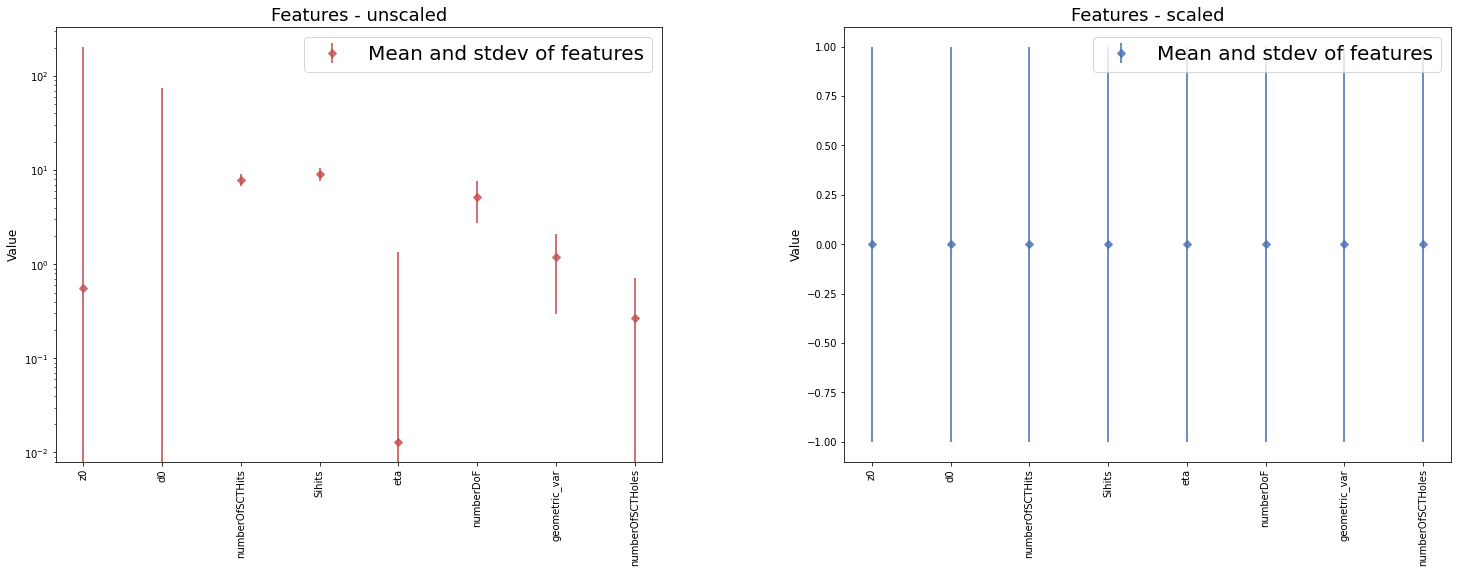

In [152]:
### Select relevant features and scale them
# This could be done with a scikitlearn utility, but we're interested in recording the exact values of scaling and offset.
# The LWTNN library uses scaling and offset information for each variable to automatically 
# pre-process the variables within athena.
dir_name = '.'

label_names = ["is_good"]

# redefined based on permutation importance
inputs_names = [ 
"z0",
"d0",
"numberOfSCTHits",
"Sihits",
"eta",
"numberDoF",
"geometric_var",
"numberOfSCTHoles",
]

# Prepare for saving information to lwtnn
# See https://github.com/dguest/lwtnn-tutorial-for-btaggers for motivation for this section
variables_json = {'inputs': [],
                  'class_labels': ["nn_score"]}

# Manual scaling to save scale and offset params for lwtnn (otherwise could use skliearn scale)
X = np.array(df[inputs_names])
X_mean = X.mean(axis=0)
X = X - X_mean # offset
X_std = X.std(axis=0)
# Don't divide by 0. These values are all the same (probably zero) and will be ignored as null values in training.
X_std[X_std==0] = 1
X = X/X_std # scale
for i in range(len(inputs_names)):
    variable_dict = {'name': inputs_names[i], 'offset': -X_mean[i], 'scale': 1/X_std[i] }
    variables_json['inputs'].append(variable_dict)

# now we save some things (create a subdirectory to keep it clean)
model_dir = dir_name+'model'
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)
print()
with open('{}/variables.json'.format(model_dir),'w') as variables:
    variables.write(json.dumps(variables_json, indent=2))
print("variables.json written to {}".format(model_dir))
    
# Don't scale this. Keep the labels binary
Y = np.array(df[label_names])

# Split into training and validation sets
X_train = X[0 : int(0.8*len(X))]
X_val =  X[int(0.8*len(X)) : len(X)]
Y_train = Y[0 : int(0.8*len(Y))]
Y_val =  Y[int(0.8*len(Y)) : len(Y)]

# Keep track of the weights
train_weights = df.weights[0 : int(0.8*len(X))]
val_weights =  df.weights[int(0.8*len(X)) : len(X)]

# Check the samples are consistent
assert(len(X_train) == len(Y_train))
assert(len(X_train) == len(train_weights))
assert(len(X_val) == len(Y_val))
assert(len(X_val) == len(val_weights))

# Plot features
X_mean_new = X.mean(axis=0)
X_std_new = X.std(axis=0)

labels = inputs_names
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,8))
ax1.semilogy(labels, np.array(X_mean), alpha=0, label='Track')
unscaled = ax1.errorbar(labels, np.array(X_mean), yerr=X_std, fmt='D', color='#C44E52', ecolor='#C44E52', linewidth=2, alpha = 0.8, label='_nolegend_')
ax1.xaxis.set_tick_params(rotation=90)
ax1.legend([unscaled],["Mean and stdev of features"], fontsize=20)
ax1.set_title("Features - unscaled", fontsize=18)
ax1.set_ylabel("Value", fontsize=12)

ax2.plot(labels, np.array(X_mean_new), alpha=0, label='Track')
scaled = ax2.errorbar(labels, np.array(X_mean_new), yerr=X_std_new, fmt='D', color='#4C72B0', ecolor='#4C72B0', linewidth=2, alpha = 0.8, label='_nolegend_')
ax2.xaxis.set_tick_params(rotation=90)
ax2.legend([scaled],["Mean and stdev of features"], fontsize=20)
ax2.set_title("Features - scaled", fontsize=18)
ax2.set_ylabel("Value", fontsize=12)

plt.subplots_adjust(wspace = 0.3)

In [238]:
### Callback functions

# Functions for visualization
# These are useful plots to watch when in a notebook environment
# They should show the learning curves of the loss function and the accuracy metric

# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.pred_good = np.array([])
        self.pred_fake = np.array([])
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharex=False)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="Training set loss")
        ax1.plot(self.x, self.val_losses, label="Validation set loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="Training set accuracy")
        ax2.plot(self.x, self.val_acc, label="Validation set accuracy")
        ax2.legend()
        
        if (epoch % 10 == 0):
            predictions = model.predict(X_val[0:1000])
            self.pred_good = predictions[Y_val.flatten()[0:1000] == 1]
            self.pred_fake = predictions[Y_val.flatten()[0:1000] == 0]

        x = [self.pred_good, self.pred_fake]
        edgecolors = ['#4C72B0','#55A868']
        for i in [0,1]:
            ax3.hist(x[i], edgecolor=edgecolors[i], histtype='step', linewidth=2.5, alpha=0.85, density=1, bins = np.linspace(0,1,90))
        ax3.set_xlabel("Value", fontsize=12)
        ax3.set_ylabel("Tracks", fontsize=12)
        ax3.set_title("NN precidction", fontsize=18)
        ax3.legend(['good', 'fake'], loc='upper center')
#         ymin, ymax = plt.ylim()
#         plt.ylim(ymin,ymax*1.1)
        plt.show();
        
plot = PlotLearning()


checkpoint_path = dir_name + "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)

# Create checkpoint callback
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_weights_only=True,
                                                  save_best_only=True,
                                                  monitor='val_loss', 
                                                  mode='min',
                                            )

# Create early stopping callback
early_stop = EarlyStopping(patience=40, restore_best_weights=True)


class GetBest(Callback):
    """Get the best model at the end of training.
    # Arguments
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            The decision
            to overwrite the current stored weights is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
    # Example
        callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]
        mode.fit(X, y, validation_data=(X_eval, Y_eval),
                 callbacks=callbacks)
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.best_epochs = 0
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('GetBest mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
                
    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            #filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can pick best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                              ' storing weights.'
                              % (epoch + 1, self.monitor, self.best,
                                 current))
                    self.best = current
                    self.best_epochs = epoch + 1
                    self.best_weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s did not improve' %
                              (epoch + 1, self.monitor))            
                    
    def on_train_end(self, logs=None):
        if self.verbose > 0:
            print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
                                                       self.best))
        self.model.set_weights(self.best_weights)
        
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
### Define the network
# Different architectures have been tested but not rigorously. A grid search my help find optimal hyperparameters.

n_variables = X_train.shape[1]
print("Input tensor shape (examples, features):", X_train.shape)

# Create model
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(n_variables, input_dim=n_variables, activation='relu'))
    model.add(keras.layers.Dense(n_variables*3, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dense(n_variables*2, activation='relu'))
#     model.add(keras.layers.Dropout(rate=0.1, seed=1))
    model.add(keras.layers.Dense(n_variables, activation='relu'))
    model.add(keras.layers.Dense(n_variables, activation='relu'))
#     model.add(keras.layers.Dropout(rate=0.1, seed=1))
#     model.add(keras.layers.Dense(12, input_dim=n_variables, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer = keras.optimizers.Adamax(lr=0.001),
                  metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model

model = create_model()
print(model.summary())

Input tensor shape (examples, features): (2391718, 8)
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

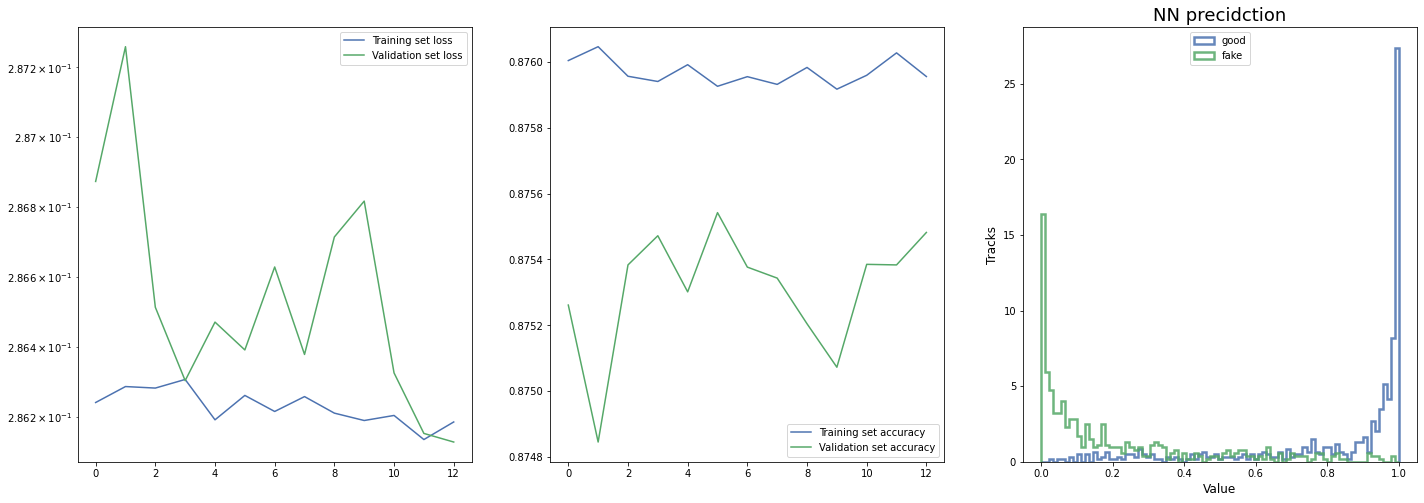


Epoch 00013: val_accuracy did not improve
240/240 [==============================] - 3s 12ms/step - loss: 0.2862 - accuracy: 0.8760 - f1_m: 0.8743 - precision_m: 0.8861 - recall_m: 0.8628 - val_loss: 0.2861 - val_accuracy: 0.8755 - val_f1_m: 0.8742 - val_precision_m: 0.8847 - val_recall_m: 0.8639
Epoch 14/100
 85/240 [=========>....................] - ETA: 1s - loss: 0.2853 - accuracy: 0.8765 - f1_m: 0.8747 - precision_m: 0.8869 - recall_m: 0.8629

KeyboardInterrupt: ignored

In [239]:
### Train model, this will take some time
# Note: this cell can be run again to train even more, as long as the model is not re-made, the optomizer will maintain its last state

# Fit the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=10000 , 
                    callbacks=[plot, early_stop, GetBest(monitor='val_accuracy', verbose=1, mode='max') ], 
                    validation_data=(X_val, Y_val, ),
#                     sample_weight = train_weights
                   )

In [240]:
# Rough evaluation of the model. See below for more precise metrics.
scores = model.evaluate(X_val, Y_val)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
18686/18686 [==============================] - 69s 4ms/step - loss: 0.2863 - accuracy: 0.8754 - f1_m: 0.8700 - precision_m: 0.8871 - recall_m: 0.8608

accuracy: 87.54%


In [251]:
### Saving the model
# Now that the model is trained, we want to save it in a format that lwtnn can use
# the lwtnn converters prefer specific formats of network models and weights.
# The lines below should save things correctly
dir_name = '/content/drive/My Drive/newhouse/Work/ATLAS/LRT/training/'

# Create a time-stamped subdirectory to keep clean records
model_dir = dir_name+'model/'+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

# Save the architecture as json
with open('{}/arch.json'.format(model_dir),'w') as archetecture:
    archetecture.write(model.to_json(indent=2, sort_keys=True) )
    
# Save the weights as hdf5
model.save_weights('{}/weights.h5'.format(model_dir), save_format='h5')

# Save the variables (calculated in previous section)
with open('{}/variables.json'.format(model_dir),'w') as variables:
    variables.write(json.dumps(variables_json, indent=2))
# print("variables.json written to {}".format(model_dir))

# Save the summary. Lwtnn doesn't require this but it can be good reference.
with open('{}/summary.txt'.format(model_dir),'w') as summary:
    model.summary(print_fn=lambda x: summary.write(x + '\n'))

# Additionally we can save the network in a format that Keras can pick up and use later
# Note: the optimizer state cannot be saved, so the network cannot be trained on further
# from its current state, but it can be used to evaluate new samples and analyze performance
model.save('{}/model-keras.json'.format(model_dir))
    
print("Model saved to {}/".format(model_dir))

INFO:tensorflow:Assets written to: /content/drive/My Drive/newhouse/Work/ATLAS/LRT/training/model/20200708_124405/model-keras.json/assets
Model saved to /content/drive/My Drive/newhouse/Work/ATLAS/LRT/training/model/20200708_124405/


In [255]:
# We can take care of converting the network to lwtnn format right here
# Note: This converter is slightly different than the one the current version of lwtnn at the time of this writing
# I needed to make a small change in the structure of the converter.
# k2j = './converters/keras2json.py'
k2j = dir_name.replace(' ', '\ ')+'converters/keras2json.py'
k2j_command = k2j + " {0}/arch.json {0}/variables.json {0}/weights.h5 > {0}/nn-config.json".format((model_dir.replace(' ', '\ ')))
print(k2j_command)
if(os.system(k2j_command) == 0): print("Success, model saved in lwtnn format\n{}/nn-config.json".format(model_dir.replace(' ', '\ ')))
else: print("Failed to save model")
    

/content/drive/My\ Drive/newhouse/Work/ATLAS/LRT/training/converters/keras2json.py /content/drive/My\ Drive/newhouse/Work/ATLAS/LRT/training/model/20200708_124405/arch.json /content/drive/My\ Drive/newhouse/Work/ATLAS/LRT/training/model/20200708_124405/variables.json /content/drive/My\ Drive/newhouse/Work/ATLAS/LRT/training/model/20200708_124405/weights.h5 > /content/drive/My\ Drive/newhouse/Work/ATLAS/LRT/training/model/20200708_124405/nn-config.json
Success, model saved in lwtnn format
/content/drive/My\ Drive/newhouse/Work/ATLAS/LRT/training/model/20200708_124405/nn-config.json


In [242]:
### Evaluate the network's performance
# Now we can look in-depth at the performance of the neural network in separating the classes
# Remember however that this is only a proxy to the true metric of performance: efficiency and fake rate
# in athena's track reconstruction algorithm. That depends on relative ordering and cannot be evaluated here
# We can however measure the discrimination power and assume that it translates to preferred ordering.

# evaluate predictions
predictions = model.predict(X_val)
print("predictions finished")
predictions_cut = predictions>0.5
print("cut finished")

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
predictions finished
cut finished


In [156]:
# It can be useful when comparing models later on to save additional performance stats to the model directory
# https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234
model_performance = {}
    
model_performance['accuracy_score'] = accuracy_score(y_true=Y_val, y_pred=predictions_cut)
print("Accuracy %.4f" % model_performance['accuracy_score'])
model_performance['f1_score'] = f1_score(y_true=Y_val, y_pred=predictions_cut)
print("F1 Score %.4f" % model_performance['f1_score'])
model_performance['precision_score'] = precision_score(y_true=Y_val, y_pred=predictions_cut)
print("Precision %.4f" % model_performance['precision_score'])
model_performance['recall_score'] = recall_score(y_true=Y_val, y_pred=predictions_cut)
print("Recall %.4f" % model_performance['recall_score'])
model_performance['confusion_matrix'] = confusion_matrix(y_true=Y_val, y_pred=predictions_cut)
print("Confusion Matrix: \n", model_performance['confusion_matrix'])    

with open('{}/model_performance.json'.format(model_dir),'w') as model_performance_file:
    json.dump(str(model_performance), model_performance_file)
print("saved to {}/model_performance.json".format(model_dir))

Accuracy 0.8737
F1 Score 0.8718
Precision 0.8865
Recall 0.8576
Confusion Matrix: 
 [[265651  32874]
 [ 42634 256771]]
saved to .model/model_performance.json


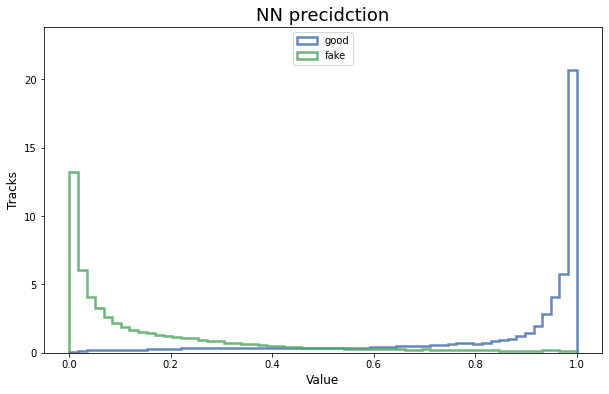

<Figure size 432x288 with 0 Axes>

In [157]:
# Visualize the NN dicriminant evaluated on good and fake tracks

pred_good = predictions[Y_val.flatten() == 1]
pred_fake = predictions[Y_val.flatten() == 0]

fig, ax1 = plt.subplots(1, 1,figsize=(10,6))
x = [pred_good, pred_fake]
edgecolors = ['#4C72B0','#55A868']
for i in [0,1]:
    ax1.hist(x[i], edgecolor=edgecolors[i], histtype='step', linewidth=2.5, alpha=0.85, density=1, bins = np.linspace(0,1,60))
ax1.set_xlabel("Value", fontsize=12)
ax1.set_ylabel("Tracks", fontsize=12)
ax1.set_title("NN precidction", fontsize=18)
ax1.legend(['good', 'fake'], loc='upper center')
# ax1.set_yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(ymin,ymax*1.1)
plt.show()
plt.savefig('{}/discriminant.png'.format(model_dir),)

# From a previous study where we would cut on some nn value to remove fakes
# for cut in [0.05,0.1,0.2,0.5,0.8]:
#     total_fake = len(pred_fake)
#     remaining_fake = len(pred_fake[pred_fake>=cut])
#     print("Cutting at {}: remaining fakes: {:.2%}".format(cut, remaining_fake/total_fake))
#     total_good = len(pred_good)
#     remaining_good = len(pred_good[pred_good>=cut])
#     print("                remaining goods: {:.2%}".format(remaining_good/total_good))
    

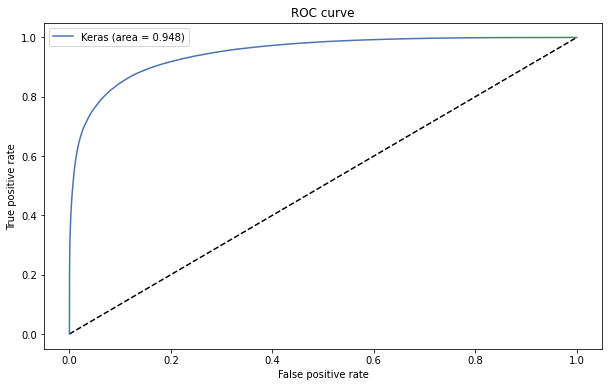

<Figure size 432x288 with 0 Axes>

In [158]:
# Plotting the ROC curve
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from sklearn.metrics import roc_curve
y_pred_keras = predictions.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_val, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1, (10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('{}/roc.png'.format(model_dir),)
# # Zoom in view of the upper left corner.
# plt.figure(2, (10,6))
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [44]:
# Permutation importance. i.e. which features were the most important
# https://www.kaggle.com/dansbecker/permutation-importance
import eli5
from eli5.sklearn import PermutationImportance
Y_df = pd.DataFrame(Y_val.ravel() == 1, columns=label_names)
X_df = pd.DataFrame(X_val, columns=inputs_names)
print(Y_df.values.flatten().shape)
print(X_df.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


(597930,)
(597930, 8)


In [46]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

my_model = KerasClassifier(build_fn=create_model)    
my_model.fit(X_train,Y_train, epochs=10, batch_size = 500)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/10
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing

KeyboardInterrupt: ignored

In [47]:
perm = PermutationImportance(my_model, random_state=1).fit(X_val,Y_val, epochs=3, batch_size = 100000)

 5763/18686 [========>.....................] - ETA: 46s - loss: 0.4492 - accuracy: 0.7939 - f1_m: 0.7917 - precision_m: 0.7866 - recall_m: 0.8076

KeyboardInterrupt: ignored

In [48]:
eli5.show_weights(perm, feature_names = X_df.columns.tolist(), top=100)

NameError: ignored

In [159]:
predictions = model.predict(X_val)


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [160]:
test_set = pd.DataFrame(X_val, columns=inputs_names)
do_scale = True

In [161]:
test_set['predictions'] = predictions.ravel()
test_set['truth'] = Y_val.ravel()


In [162]:
test_set

,z0,d0,numberOfSCTHits,Sihits,eta,numberDoF,geometric_var,numberOfSCTHoles,predictions,truth
0,-1.984593,-0.676183,-0.855821,-0.710583,0.677535,-0.488774,1.189113,1.662094,0.003660,False
1,-1.416640,-0.431415,-0.855821,-0.710583,-0.234054,-0.488774,-0.040340,-0.601651,0.101037,False
2,1.491065,0.650431,0.078384,-0.710583,1.094221,-0.901952,-1.000356,-0.601651,0.611418,True
3,-0.322777,-0.224876,-0.855821,-0.033534,1.368543,0.337582,1.505264,1.662094,0.252078,True
4,-0.181458,0.056799,0.078384,-0.710583,0.845836,-0.901952,1.445640,-0.601651,0.938871,True
...,...,...,...,...,...,...,...,...,...,...
597925,0.179685,0.286189,1.012590,-0.033534,-1.004741,-0.488774,1.071109,-0.601651,0.971631,True
597926,0.660640,0.508238,-0.855821,-0.710583,-1.195652,-0.488774,1.441592,1.662094,0.020525,False
597927,-0.076497,-0.751278,1.946795,0.643515,-0.756820,-0.075596,-0.629866,-0.601651,0.984246,True
597928,-0.048640,-0.046848,2.881001,2.674663,0.407772,1.990293,0.367216,-0.601651,0.998680,True


In [169]:
unscaled_test_set = pd.DataFrame()
for mean, std, col in zip(X_mean, X_std, test_set.columns):
  print(mean, std, col)
  # unscale and unshift
  unscaled_test_set[col] = test_set[col]*std + mean
unscaled_test_set['predictions'] = test_set['predictions']
unscaled_test_set['truth'] = test_set['truth']

0.5579547054354418 204.55289441814242 z0
-2.635703316642451 77.57128799576894 d0
7.916095138959503 1.0704283093515243 numberOfSCTHits
9.04952924223855 1.4769976386183998 Sihits
0.01294713802137038 1.340021629825517 eta
5.182963345517599 2.4202648964986633 numberDoF
1.1863936199722547 0.8933307465897727 geometric_var
0.2657767737205183 0.4417459453930852 numberOfSCTHoles


In [170]:
unscaled_test_set.describe()

,z0,d0,numberOfSCTHits,Sihits,eta,numberDoF,geometric_var,numberOfSCTHoles,predictions
count,597930.000000,597930.000000,597930.000000,597930.000000,597930.000000,597930.000000,5.979300e+05,597930.000000,597930.000000
mean,0.145017,-2.598907,7.916099,9.049365,0.013048,5.182632,1.185543e+00,0.266026,0.503215
std,204.793900,77.570817,1.070637,1.476103,1.340069,2.418512,8.929166e-01,0.441878,0.399338
min,-499.997330,-299.842419,2.000000,6.000000,-2.689074,1.000000,4.063888e-07,0.000000,0.000287
25%,-114.936472,-36.102601,7.000000,8.000000,-1.101206,4.000000,3.612663e-01,0.000000,0.081156
50%,0.583398,-3.373494,8.000000,8.000000,0.012681,4.000000,9.913111e-01,0.000000,0.456375
75%,115.477447,29.385239,8.000000,10.000000,1.124654,6.000000,1.999304e+00,1.000000,0.955449
max,499.901019,298.223497,18.000000,21.000000,2.694963,25.000000,2.996917e+00,1.000000,1.000000


                z0          d0  ...  predictions  truth
2       305.559552   47.819048  ...     0.611418   True
3       -65.467111  -20.079597  ...     0.252078   True
4       -36.559888    1.770244  ...     0.938871   True
8       136.281597 -181.093588  ...     0.290789   True
9       -13.069882  -33.805648  ...     0.951198   True
...            ...         ...  ...          ...    ...
597923  131.157346   12.713296  ...     0.999569   True
597924 -116.759116  -19.207735  ...     0.998975   True
597925   37.312987   19.564352  ...     0.971631   True
597927  -15.089800  -60.913300  ...     0.984246   True
597928   -9.391496   -6.269781  ...     0.998680   True

[299405 rows x 10 columns]
                z0          d0  ...  predictions  truth
0      -405.396208  -55.088065  ...     0.003660  False
1      -289.219896  -36.101133  ...     0.101037  False
5       -11.766423  -91.942785  ...     0.767034  False
6      -185.098530  106.925149  ...     0.043731  False
7      -458.194876  

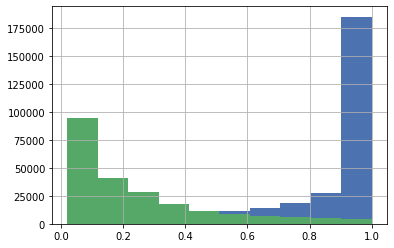

In [171]:

good_query = 'truth == True'
fake_query = 'truth == False'
# Create slices for convenience
good = unscaled_test_set.query(good_query)
fake = unscaled_test_set.query(fake_query)
# apply cut
cut_query = 'predictions > 0.02'
new_good = good.query(cut_query)
new_fake = fake.query(cut_query)

print(good)
print(fake)

new_good.predictions.hist()
new_fake.predictions.hist()


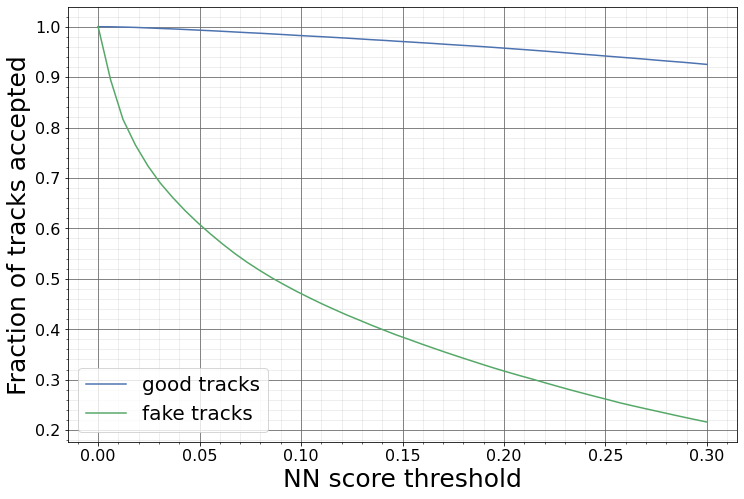

In [231]:
cut_vals = np.linspace(0,.3,50)
signal_acc = []
background_rej = []
for cut_val in cut_vals:
  cut_query = f'predictions > {cut_val}'
  # print(f'cut at nn score of {cut_val}')
  signal_acc.append(len(good.query(cut_query))/len(good))
  background_rej.append(len(fake.query(cut_query))/len(fake))

plt.figure(figsize=(12,8))
plt.plot(cut_vals, signal_acc)
plt.plot(cut_vals, background_rej)
ax = plt.gca()

# Show the major grid lines with dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('NN score threshold',  fontsize=25)
ax.set_ylabel('Fraction of tracks accepted', fontsize=25)
ax.legend(['good tracks', 'fake tracks'], fontsize=20)


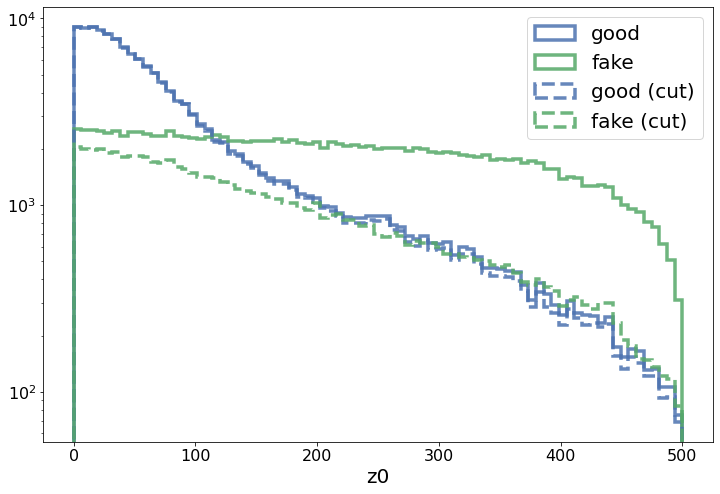

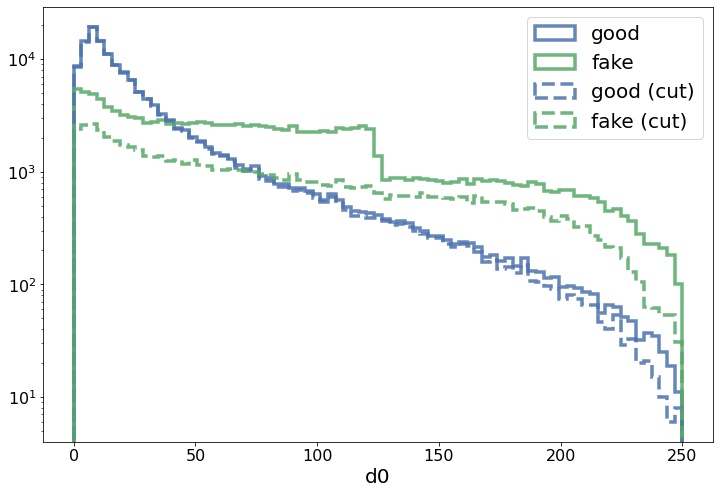

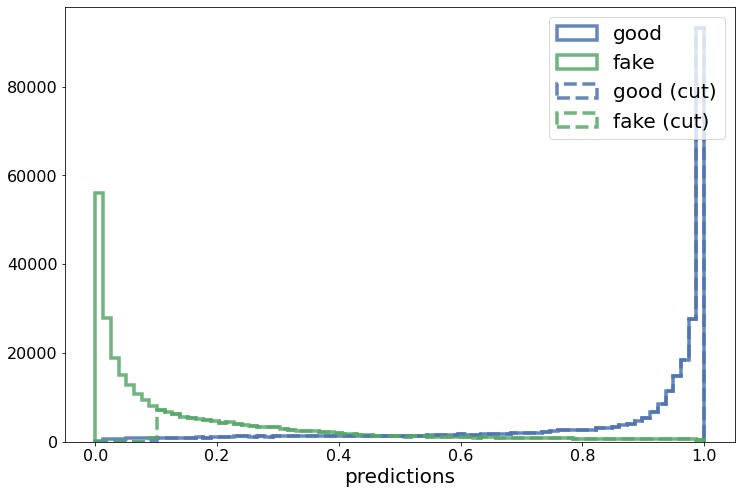

In [235]:
def test_cut(x, cut_query, bins=np.linspace(0,1,11), leg_loc='upper left', log=False):
    df = unscaled_test_set
    plot_options = {
        'histtype' : 'step',
        'linewidth' : 3.5, 
        'alpha' : 0.85, 
        'density' : None,
        'bins' : bins,
        'log' : log
    }

    good_query = 'truth == 1'
    fake_query = 'truth == 0'
    # Create slices for convenience
    good = df.query(good_query)
    fake = df.query(fake_query)
    # apply cut
    new_good = good.query(cut_query)
    new_fake = fake.query(cut_query)

    good_vals = ax.hist(good[x], edgecolor='#4C72B0', **plot_options)
    fake_vals = ax.hist(fake[x], edgecolor='#55A868', **plot_options)
    good_vals = ax.hist(new_good[x], edgecolor='#4C72B0', linestyle='--', **plot_options)
    fake_vals = ax.hist(new_fake[x], edgecolor='#55A868', linestyle='--',  **plot_options)
    ax.legend(['good', 'fake', 'good (cut)', 'fake (cut)'], loc=leg_loc, fontsize=20)
    ax.set_xlabel(x, fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    return ax

cut_val = 0.1
cut_query = f'predictions > {cut_val}'
fig, ax = plt.subplots(1, 1,figsize=(12,8))
test_cut('z0', cut_query, bins=np.linspace(0,500,80), leg_loc='upper right', log=True)
fig, ax = plt.subplots(1, 1,figsize=(12,8))
test_cut('d0', cut_query, bins=np.linspace(0,250,80), leg_loc='upper right', log=True)
fig, ax = plt.subplots(1, 1,figsize=(12,8))
test_cut('predictions', cut_query, bins=np.linspace(0,1,80), leg_loc='upper right', log=False)
# fig, ax = plt.subplots(1, 1,figsize=(12,8))
# test_cut('truthProbability', cut_query, bins=np.linspace(0,1,11), leg_loc='upper left')


In [190]:
1 - len(good.query(cut_query))/len(good)

0.01763497603580433

In [189]:
1 - len(fake.query(cut_query))/len(fake)

0.5293995477765681